In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans


high_fee = pd.read_parquet('lp_analysis_output_weth_dai_events_3000.parquet')
low_fee = pd.read_parquet('lp_analysis_output_weth_dai_events_500.parquet')

high_fee['date'] = pd.to_datetime(high_fee.evt_block_time).dt.normalize()
low_fee['date'] = pd.to_datetime(low_fee.evt_block_time).dt.normalize()

end_date = min(high_fee['date'].max(),low_fee.date.max())

high_fee = high_fee[high_fee.date <= end_date]
low_fee = low_fee[low_fee.date <= end_date]

both = pd.concat([high_fee, low_fee], ignore_index=True).sort_values('evt_block_time')


In [48]:
exclude_cols = ['amount0','amount1','event','date','evt_block_time',
                'price','pool_liquidity','volume_proxy',"('0x', 0.0, 0.0)"]

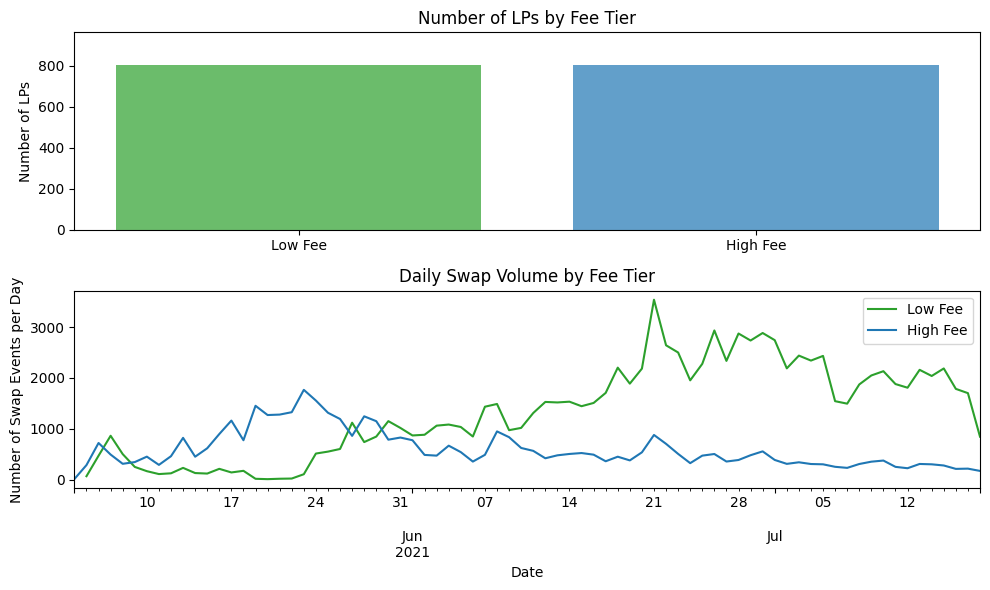

In [57]:
lp_cols_low = [i for i in low_fee.columns if ('fee' not in i) & ('inventory' not in i)  & (i not in exclude_cols)]
lp_cols_high = [i for i in low_fee.columns if ('fee' not in i) & ('inventory' not in i) &  (i not in exclude_cols)]


# Number of LPs
n_lps_low = len(lp_cols_low)
n_lps_high = len(lp_cols_high)

# Daily volumes
daily_vol_low = both[both.fee_rate == 500].groupby('date').size()
daily_vol_high = both[both.fee_rate == 3000].groupby('date').size()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

# num of LPs by fee type
ax1.bar(['Low Fee', 'High Fee'], [n_lps_low, n_lps_high], color=['tab:green', 'tab:blue'], alpha=0.7)
ax1.set_ylabel('Number of LPs')
ax1.set_title('Number of LPs by Fee Tier')
ax1.set_ylim(0, max(n_lps_low, n_lps_high)*1.2)

#  daily volume by fee tier
daily_vol_low.plot(ax=ax2, label='Low Fee', color='tab:green')
daily_vol_high.plot(ax=ax2, label='High Fee', color='tab:blue')
ax2.set_ylabel('Number of Swap Events per Day')
ax2.set_xlabel('Date')
ax2.set_title('Daily Swap Volume by Fee Tier')
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:

exclude_cols = ['amount0','amount1','event','date','evt_block_time','price','pool_liquidity','volume_proxy',"('0x', 0.0, 0.0)"]
all_lps = lp_cols_high + lp_cols_low

lp_df = pd.DataFrame(index = all_lps)

import ast

for lp in all_lps:
    if lp in both.columns:
        addr, lower_tick, upper_tick = ast.literal_eval(lp)
        fee_0_str = lp + '_fee_0' # fees awarded every step
        fee_1_str = lp + '_fee_1'
        inventory_column_0 = lp + '_inventory_0'
        inventory_column_1 = lp + '_inventory_1'

        vol = np.where(
        both['event'].eq('swap'),
            both[inventory_column_0].diff().abs() * both['price'], # total volume in token0, dollarized
            0
        )
        total_vol = np.nansum(vol) 
        time_in_range = len(vol[vol>0]) # non-zero diffs mean time in range    
        dollars_fees = (both.price * both[fee_0_str]) + (both[fee_1_str]) # all fees you got, every time step
        
        raw_size = both[lp].astype(float).max()
        position_width = abs(int(upper_tick) - int(lower_tick))
        lp_df.loc[lp, 'lp_position_size'] = raw_size
        lp_df.loc[lp, 'lp_position_width'] = position_width
        lp_df.loc[lp, 'lp_size_per_tick'] = raw_size / position_width
        lp_df.loc[lp,'lp_total_fees'] = dollars_fees.sum()
        lp_df.loc[lp,'lp_total_volume'] = total_vol # a single number 
        lp_df.loc[lp,'lp_time_in_range'] = time_in_range
        lp_df.loc[lp,'lp_lifetime'] = (both[lp] > 0).sum() # L > 0 means alive
        lp_df.loc[lp,'lp_position_size'] = both[lp].astype(float).max() # size is the MAX L you ever had
        lp_df.loc[lp,'pool'] = 3000 if lp in lp_cols_high else 500
lp_df['lp_liquidity-time-in-range'] = lp_df['lp_position_size'] * lp_df['lp_time_in_range']


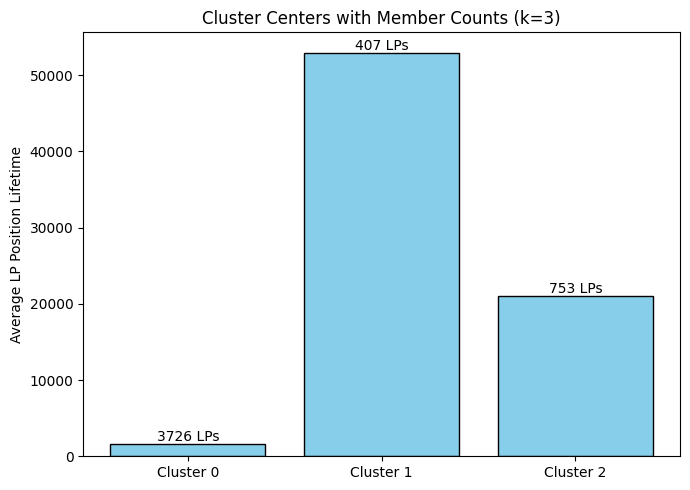

In [51]:


k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
X = lp_df[['lp_lifetime']].values
lp_df['cluster'] = kmeans.fit_predict(X)
lp_df['cluster_center'] = kmeans.cluster_centers_[lp_df['cluster']]

# Get cluster centers and counts
centers = kmeans.cluster_centers_.flatten()
counts = lp_df['cluster'].value_counts().sort_index()

x = np.arange(k)

plt.figure(figsize=(7,5))
bars = plt.bar(x, centers, color='skyblue', edgecolor='black')

# Add member count labels above each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{counts[i]} LPs',
             ha='center',
             va='bottom',
             fontsize=10)

plt.xticks(x, [f'Cluster {i}' for i in x])
plt.ylabel('Average LP Position Lifetime')
plt.title('Cluster Centers with Member Counts (k=3)')
plt.tight_layout()
plt.show()


(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

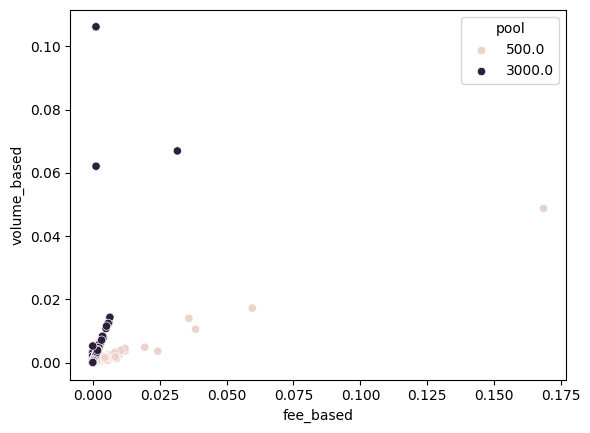

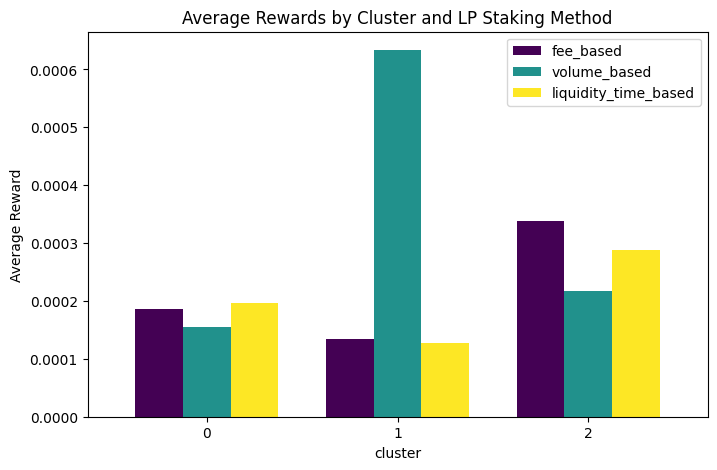

In [54]:
lp_df['total_volume'] = lp_df.lp_total_volume.sum()
lp_df['total_liquidity_time'] = lp_df['lp_liquidity-time-in-range'].sum()
lp_df['total_fees'] = lp_df.lp_total_fees.sum()

lp_df['fee_based'] = lp_df.lp_total_fees / lp_df.total_fees
lp_df['volume_based'] = lp_df.lp_total_volume / lp_df.total_volume
lp_df['liquidity_time_based'] = lp_df['lp_liquidity-time-in-range'] / lp_df.total_liquidity_time

sns.scatterplot(
    data = lp_df,
    x = 'fee_based',
    y = 'volume_based',
    hue = 'pool'
)

cluster_summary = (
    lp_df
    .groupby('cluster')[['fee_based','volume_based','liquidity_time_based']]
    .mean()
    .sort_index()
)
cluster_summary.plot(
    kind='bar',
    figsize=(8,5),
    width=0.75,
    colormap='viridis'
)

plt.ylabel('Average Reward')
plt.title('Average Rewards by Cluster and LP Staking Method')
plt.xticks(rotation=0)